## 二维互相关运算的实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  
    """计算二维互相关运算"""
    h, w = K.shape
    # 初始化输出矩阵
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    # 逐一计算输出矩阵中的各个元素值
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() # X与K求点积再求和，stride=1
    return Y

通过输入X以及卷积核K的shape能够计算出输出矩阵Y的尺寸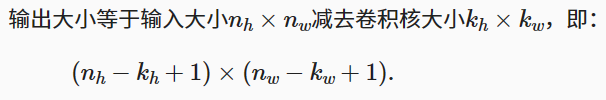

In [2]:
# 验证二维互相关运算
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 卷积层Conv2D的实现
卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。卷积层中的两个被训练的参数是卷积核权重和标量偏置

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, X):
        return corr2d(X, self.weight) + self.bias

## 图像中目标的边缘检测

In [4]:
# 简单应用：通过像素变化的位置，检测图像中不同颜色的边缘，0-黑色，1-白色
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
# 手动设计能实现此功能的卷积核，如果水平相邻的两元素相同，则输出为零，否则输出为非零。(只能检测垂直边缘)
K = torch.tensor([[1.0, -1.0]])

In [8]:
# 输出是6 x 7
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
corr2d(X.t(), K) # 显然此卷积核无法检测水平边缘

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习出卷积核
通过仅查看“输入-输出”来学习由X生成Y的卷积核

In [12]:
# 构造一个二维卷积层，它具有1个输入通道，1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小batch_size、通道channel、高度h、宽度w），
# 此处的批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7)) # Y的h和w是通过X与K计算出来的
lr = 3e-2 # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2  # 均方误差
    conv2d.zero_grad()
    l.sum().backward()
    # 梯度下降,迭代卷积核参数
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 9.096
epoch 4, loss 1.550
epoch 6, loss 0.270
epoch 8, loss 0.049
epoch 10, loss 0.010


In [13]:
conv2d.weight.data.reshape(1, 2)

tensor([[ 0.9899, -0.9789]])

我们学习到的卷积核权重非常接近我们之前定义的卷积核K

学习卷积核时，无论用严格卷积运算或互相关运算，卷积层的输出不会受太大影响

当需要检测输入特征中更广区域时，我们可以构建一个更深的卷积网络